## Task 1: Logistic Regression Implementation from Scratch
### Hate Speech Detection using Logistic Regression

This notebook implements a Logistic Regression model from scratch without using sklearn's LogisticRegression or any other pre-defined logistic regression packages.

**Task Deliverables:**
- 1a. Code implementation of the Logistic Regression model
- 1b. Prediction made by Logistic Regression on Test set saved as "LogRed_Prediction.csv"

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

### 2. Logistic Regression Class Implementation from Scratch

In [15]:
class LogisticRegression:
    """
    Logistic Regression implementation from scratch
    """
    def __init__(self):
        self.weights = None
        self.bias = None
        self.cost_history = []

    @staticmethod
    def sigmoid(z):
        """
        Sigmoid activation function
        """
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    @staticmethod
    def loss(y, y_hat):
        """
        Log loss function
        """
        epsilon = 1e-15
        y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
        m = y.shape[0]
        return -(1/m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    @staticmethod
    def gradients(X, y, y_hat):
        """
        Compute gradients for weights and bias
        """
        m = X.shape[0]
        dw = (1/m) * np.dot(X.T, (y_hat - y))
        db = (1/m) * np.sum(y_hat - y)
        return dw, db

    def train(self, X, y, bs=64, epochs=10, lr=0.01):
        """
        Train the logistic regression model using mini-batch gradient descent
        """
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        self.cost_history = []

        for epoch in range(epochs):
            # Shuffle the data at the start of each epoch
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start in range(0, m, bs):
                end = min(start + bs, m)
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                z = np.dot(X_batch, self.weights) + self.bias
                y_hat = self.sigmoid(z)

                dw, db = self.gradients(X_batch, y_batch, y_hat)

                self.weights -= lr * dw
                self.bias -= lr * db

            # Compute loss for the whole dataset at the end of each epoch
            y_hat_full = self.sigmoid(np.dot(X, self.weights) + self.bias)
            cost = self.loss(y, y_hat_full)
            self.cost_history.append(cost)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {cost:.6f}")

        print(f"Training completed after {epochs} epochs.")
        return self

    def predict(self, X, threshold=0.5):
        """
        Predict class labels
        """
        z = np.dot(X, self.weights) + self.bias
        probabilities = self.sigmoid(z)
        return (probabilities >= threshold).astype(int)

    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def plot_cost_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.cost_history)
        plt.title('Cost Function History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

### 3. Data Loading and Preparation Functions

In [16]:
def load_and_prepare_data():
    """
    Load and prepare the training and test data
    """
    print("Loading training data...")
    train_data = pd.read_csv('data/train_tfidf_features.csv')
    
    print("Loading test data...")
    test_data = pd.read_csv('data/test_tfidf_features.csv')
    
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    
    # Separate features and labels
    X_train = train_data.drop(['id', 'label'], axis=1).values
    y_train = train_data['label'].values
    
    X_test = test_data.drop(['id'], axis=1).values
    
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    
    # Check for any missing values
    print(f"Missing values in X_train: {np.isnan(X_train).sum()}")
    print(f"Missing values in y_train: {np.isnan(y_train).sum()}")
    print(f"Missing values in X_test: {np.isnan(X_test).sum()}")
    
    # Handle any missing values
    X_train = np.nan_to_num(X_train, nan=0.0)
    X_test = np.nan_to_num(X_test, nan=0.0)
    
    return X_train, y_train, X_test, train_data['id'].values, test_data['id'].values

### 4. Model Evaluation and Submission Functions

In [17]:
def evaluate_model(model, X, y, dataset_name="Dataset"):
    """
    Evaluate the model and print metrics
    """
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"\n{dataset_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['Non-Hateful', 'Hateful']))
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Hateful', 'Hateful'],
                yticklabels=['Non-Hateful', 'Hateful'])
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy, y_pred

### Submission File Creation Function

In [18]:
def create_submission(predictions, test_ids, filename='LogRed_Prediction.csv'):
    """
    Create submission file in the required format
    """
    submission_df = pd.DataFrame({
        'id': test_ids,
        'label': predictions
    })
    submission_df.to_csv(filename, index=False)
    print(f"Submission file saved as {filename}")
    
    # Show first few predictions
    print("\nFirst 10 predictions:")
    print(submission_df.head(10))

### 5. Load and Explore the Data

In [19]:
print("=== Hate Speech Detection using Logistic Regression ===")
X_train, y_train, X_test, train_ids, test_ids = load_and_prepare_data()
print(f"\nClass distribution in training data:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples ({count/len(y_train)*100:.2f}%)")

=== Hate Speech Detection using Logistic Regression ===
Loading training data...
Loading test data...
Training data shape: (17184, 5002)
Test data shape: (4296, 5001)
X_train shape: (17184, 5000)
y_train shape: (17184,)
X_test shape: (4296, 5000)
Missing values in X_train: 0
Missing values in y_train: 0
Missing values in X_test: 0

Class distribution in training data:
Class 0: 10633 samples (61.88%)
Class 1: 6551 samples (38.12%)


### 7. Train the Logistic Regression Model

This section trains our model:
- **Model initialization**: Creates a new LogisticRegression instance
- **Training parameters**:
  - `bs=64`
  - `epochs=1000`
  - `lr=0.01`
- **Progress tracking**: Prints loss after each epoch


=== Training Logistic Regression Model ===
Epoch 1/1000 - Loss: 0.671913
Epoch 2/1000 - Loss: 0.666106
Epoch 3/1000 - Loss: 0.664375
Epoch 4/1000 - Loss: 0.663632
Epoch 5/1000 - Loss: 0.663184
Epoch 6/1000 - Loss: 0.662813
Epoch 7/1000 - Loss: 0.662477
Epoch 8/1000 - Loss: 0.662150
Epoch 9/1000 - Loss: 0.661826
Epoch 10/1000 - Loss: 0.661503
Epoch 11/1000 - Loss: 0.661179
Epoch 12/1000 - Loss: 0.660857
Epoch 13/1000 - Loss: 0.660538
Epoch 14/1000 - Loss: 0.660219
Epoch 15/1000 - Loss: 0.659901
Epoch 16/1000 - Loss: 0.659585
Epoch 17/1000 - Loss: 0.659270
Epoch 18/1000 - Loss: 0.658957
Epoch 19/1000 - Loss: 0.658643
Epoch 20/1000 - Loss: 0.658332
Epoch 21/1000 - Loss: 0.658021
Epoch 22/1000 - Loss: 0.657712
Epoch 23/1000 - Loss: 0.657403
Epoch 24/1000 - Loss: 0.657096
Epoch 25/1000 - Loss: 0.656791
Epoch 26/1000 - Loss: 0.656485
Epoch 27/1000 - Loss: 0.656182
Epoch 28/1000 - Loss: 0.655878
Epoch 29/1000 - Loss: 0.655577
Epoch 30/1000 - Loss: 0.655276
Epoch 31/1000 - Loss: 0.654976
Epoc

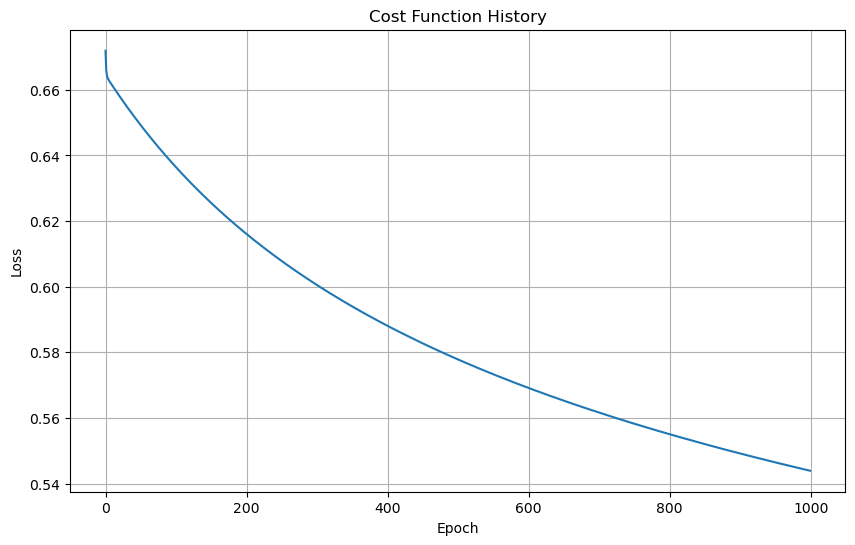

In [20]:
print("\n=== Training Logistic Regression Model ===")
model = LogisticRegression()
# You can adjust batch size, epochs, and learning rate as needed
model.train(X_train, y_train, bs=64, epochs=1000, lr=0.01)
model.plot_cost_history()

### 8. Evaluate Model on Training Data

This section evaluates how well our model learned from the training data:
- **Training accuracy**: Measures performance on data the model was trained on
- **Classification metrics**: Shows detailed performance for each class
- **Confusion matrix**: Visualizes prediction accuracy
- **Performance assessment**: Helps identify if the model is learning properly


Training Results:
Accuracy: 0.7288

Classification Report:
              precision    recall  f1-score   support

 Non-Hateful       0.72      0.92      0.81     10633
     Hateful       0.76      0.42      0.54      6551

    accuracy                           0.73     17184
   macro avg       0.74      0.67      0.67     17184
weighted avg       0.74      0.73      0.71     17184



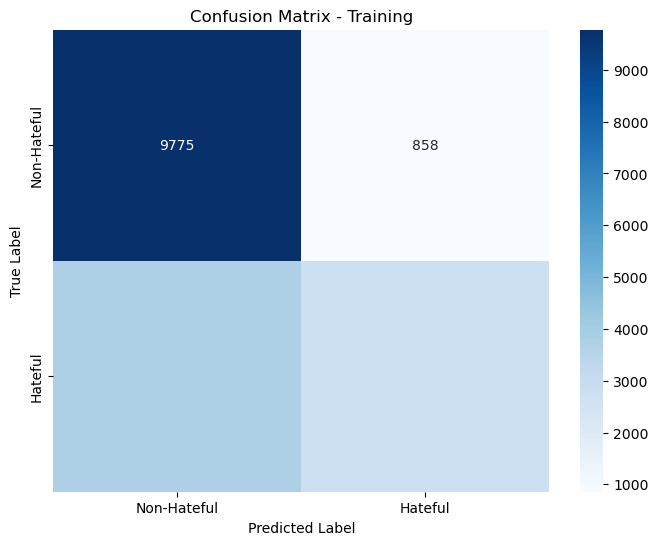

In [21]:
train_accuracy, train_predictions = evaluate_model(model, X_train, y_train, "Training")

### 9. Make Predictions on Test Data

This section generates final predictions:
- **Test predictions**: Uses trained model to predict labels for unseen test data
- **Submission file**: Creates the required CSV file with ID and label columns
- **File output**: Saves as 'LogRed_Prediction.csv' as specified in task requirements
- **Preview**: Shows first 10 predictions for verification

In [22]:
print("\n=== Making Predictions on Test Data ===")
test_predictions = model.predict(X_test)
create_submission(test_predictions, test_ids, 'LogRed_Prediction.csv')


=== Making Predictions on Test Data ===
Submission file saved as LogRed_Prediction.csv

First 10 predictions:
      id  label
0  17185      0
1  17186      0
2  17187      1
3  17188      0
4  17189      0
5  17190      0
6  17191      1
7  17192      0
8  17193      1
9  17194      0


### 10. Model Summary and Statistics

In [23]:
print("\n=== Model Summary ===")
print(f"Final training accuracy: {train_accuracy:.4f}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")


=== Model Summary ===
Final training accuracy: 0.7288
Number of features: 5000
Number of training samples: 17184
Number of test samples: 4296


## 11. Example Predictions with Probabilities

This final section shows detailed examples:
- **Random sampling**: Selects 10 random training samples
- **Prediction comparison**: Shows true labels vs predicted labels
- **Probability scores**: Displays the confidence (probability) for each prediction

In [24]:
print("\n=== Example Predictions ===")
sample_indices = np.random.choice(len(X_train), 10, replace=False)
sample_X = X_train[sample_indices]
sample_y = y_train[sample_indices]
sample_pred = model.predict(sample_X)
sample_proba = model.predict_proba(sample_X)
for i, (true_label, pred_label, proba) in enumerate(zip(sample_y, sample_pred, sample_proba)):
    print(f"Sample {i+1}: True={true_label}, Pred={pred_label}, Probability={proba:.4f}")


=== Example Predictions ===
Sample 1: True=0, Pred=0, Probability=0.1615
Sample 2: True=1, Pred=1, Probability=0.5484
Sample 3: True=1, Pred=1, Probability=0.5064
Sample 4: True=0, Pred=0, Probability=0.1679
Sample 5: True=1, Pred=0, Probability=0.3731
Sample 6: True=0, Pred=0, Probability=0.0991
Sample 7: True=0, Pred=0, Probability=0.2142
Sample 8: True=0, Pred=0, Probability=0.2206
Sample 9: True=0, Pred=0, Probability=0.2070
Sample 10: True=0, Pred=0, Probability=0.2290


Score based on kaggle submission: 0.79771